In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
start_seeds = [0, 5 ,10, 15, 20,] #

exp0_dir = f'./full_exp/'

options_list = [
    (False, False, None),
    #(True, False),
    #(False, True),
    (True, True, None),
    (False, False, True),
    (False, True, True),
]
# sharpes_all_train = {}
# sharpes_all_eval = {}
# sharpes_all_test = {}
# best_seed_all = {}

# all_R_eval = {}



# for adapt_reward, adapt_state, last_rew in options_list:
#         sharpes_all_train[(adapt_reward, adapt_state, last_rew)] = []
#         sharpes_all_eval[(adapt_reward, adapt_state, last_rew)] = []
#         sharpes_all_test[(adapt_reward, adapt_state, last_rew)] = []
#         best_seed_all[(adapt_reward, adapt_state, last_rew)] = []
#         all_R_eval[(adapt_reward, adapt_state, last_rew)] = []
#         for seed_start in start_seeds:
#             exp_dir = exp0_dir + f'{seed_start=}/'
#             if last_rew is None:
#                 log_dir=os.path.join(exp_dir, f'log_{adapt_reward=}_{adapt_state=}')
#             else:
#                 log_dir=os.path.join(exp_dir, f'log_{adapt_reward=}_{adapt_state=}_only_last_reward={last_rew}')
#             tensorboard_dir = os.path.join(exp_dir, f"tensorboard_{adapt_reward=}_{adapt_state=}")
#             with open(os.path.join(log_dir, "sharpe_train.npy"), "rb") as f:
#                 sharpe_train = np.load(f)
#             with open(os.path.join(log_dir, "sharpe_test.npy"), "rb") as f:
#                 sharpe_test = np.load(f)
#             with open(os.path.join(log_dir, "sharpe_eval.npy"), "rb") as f:
#                 sharpe_eval = np.load(f)
#             with open(os.path.join(log_dir, "best_model_seed.npy"), "rb") as f:
#                 best_seed = np.load(f)
#             with open(os.path.join(log_dir, "all_R_eval.pkl"), "rb") as f:
#                 R_eval = pickle.load(f)
#             sharpes_all_train[(adapt_reward, adapt_state, last_rew)].append(sharpe_train)
#             sharpes_all_eval[(adapt_reward, adapt_state, last_rew)].append(sharpe_eval)
#             sharpes_all_test[(adapt_reward, adapt_state, last_rew)].append(sharpe_test)
#             best_seed_all[(adapt_reward, adapt_state, last_rew)].append(best_seed)
#             all_R_eval[(adapt_reward, adapt_state, last_rew)].append(R_eval)
# for adapt_reward, adapt_state, last_rew in options_list:
#     sharpes_all_eval[(adapt_reward, adapt_state, last_rew)] = np.array(sharpes_all_eval[(adapt_reward, adapt_state, last_rew)])
#     sharpes_all_test[(adapt_reward, adapt_state, last_rew)] = np.array(sharpes_all_test[(adapt_reward, adapt_state, last_rew)])

In [4]:
with open("sharpes_all_train.pkl", "rb") as f:
    sharpes_all_train = pickle.load(f)

In [5]:
mean_sharpes_train = {}
std_sharpes_train = {}
for adapt_reward, adapt_state, last_rew in options_list:
    mean_sharpes_train[(adapt_reward, adapt_state, last_rew)] = np.mean(np.concatenate(sharpes_all_train[(adapt_reward, adapt_state, last_rew)]))
    std_sharpes_train[(adapt_reward, adapt_state, last_rew)] = np.std(np.mean(sharpes_all_train[(adapt_reward, adapt_state, last_rew)], axis=(1,2)))
    print(fr"mean sharpe train {adapt_reward=} {adapt_state=} {last_rew=}: {mean_sharpes_train[(adapt_reward, adapt_state, last_rew)]}+-{std_sharpes_train[(adapt_reward, adapt_state, last_rew)]}")

mean sharpe train adapt_reward=False adapt_state=False last_rew=None: 10.50635217375145+-1.650162012938233
mean sharpe train adapt_reward=True adapt_state=True last_rew=None: 13.32820967494807+-1.1446104255912535
mean sharpe train adapt_reward=False adapt_state=False last_rew=True: 0.6930213672395727+-0.05956283982986679
mean sharpe train adapt_reward=False adapt_state=True last_rew=True: 0.6882325568768326+-0.033507251069872394


In [6]:
def bootstrap_ci(data, n_resamples=10000, ci=90):
    """
    data: numpy array of shape (a, b, c)
    Returns: tuple (mean, lower_ci, upper_ci), each of shape (b,)
    """
    a, b, c = data.shape
    means = np.zeros((n_resamples, b))
    for i in range(n_resamples):
        # Resample along axis 0 and 2
        idx_a = np.random.randint(0, a, a)
        idx_c = np.random.randint(0, c, c)
        sample = data[idx_a][:, :, idx_c]
        means[i] = sample.mean(axis=(0, 2))
    
    lower = np.percentile(means, (100 - ci) / 2, axis=0)
    upper = np.percentile(means, 100 - (100 - ci) / 2, axis=0)
    mean = data.mean(axis=(0, 2))
    return mean, lower, upper

(5, 10, 5)
(5, 10, 5)
(5, 10, 5)
(5, 10, 5)


Text(0, 0.5, 'sharpe train')

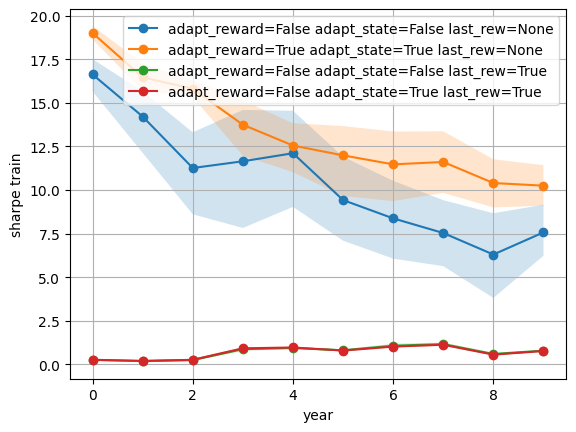

In [7]:
for adapt_reward, adapt_state, last_rew  in options_list:
    max_idx = min([len(ar) for ar in sharpes_all_train[(adapt_reward, adapt_state, last_rew)]])
    cut_rel_sharpes_train = np.array([ar[:max_idx] for ar in sharpes_all_train[(adapt_reward, adapt_state, last_rew)]])
    print(cut_rel_sharpes_train.shape)
    mean, lower, upper = bootstrap_ci(cut_rel_sharpes_train, n_resamples=10000, ci=95)
    # plot mean and shade confidence interval
    plt.plot(range(max_idx), mean, label=f"{adapt_reward=} {adapt_state=} {last_rew=}",
             marker='o')
    plt.fill_between(range(max_idx), lower, upper, alpha=0.2)
    #plt.ylim(0, 1.5)
    # plt.errorbar(range(max_idx), mean, 
    #              np.std(cut_rel_sharpes_train, axis=(0,2)), label=f"{adapt_reward=} {adapt_state=} {last_rew=}",
    #              marker='o')
plt.legend()
plt.grid()
plt.xlabel("year")
plt.ylabel("sharpe train")